In [1]:
using DelimitedFiles
using LinearAlgebra
using PyPlot
include("functions/num2color.jl");

## 0. Choose protein and prevalence landscape

In [2]:
####################################################################################################
# To edit this code:
# * change protein, polyprotein, polyprotein1
####################################################################################################

protein="p24"
polyprotein="gag"
polyprotein1="Gag"
L=231;

In [3]:
ising_params0=readdlm("p24 landscape/p24-g2-0.0005-b-5870-gh-0.001/p24-out-learn.j")

# convert to square matrix
ising_params=zeros(L,L)
for i=1:L
    ising_params[i,i]=ising_params0[i]
end
for i=1:L
    for j=i+1:L
        ising_params[i,j]=ising_params0[round(Int,L+(L-1)*L/2-(L-i)*(L-i+1)/2+(j-i))]
        ising_params[j,i]=ising_params[i,j]
    end
end

## I. Choose patient

In [4]:
####################################################################################################
# To edit this code:
# * change patientid
####################################################################################################

patientid="CH058"
# patientid="CH077"
# patientid="CH159"

patientnames=Dict(
    "CH040"=>"700010040",
    "CH058"=>"700010058",
    "CH077"=>"700010077",
    "CH470"=>"700010470",
    "CH607"=>"700010607",
    "CH131"=>"703010131",
    "CH159"=>"703010159",
    "CH256"=>"703010256",
    "CH042"=>"704010042",
    "CH067"=>"705010067",
    "CH162"=>"705010162",
    "CH185"=>"705010185",
    "CH198"=>"705010198",
    "CH164"=>"706010164",
    "CAP045"=>"CAP45",
    "CAP210"=>"CAP210",
    "CAP239"=>"CAP239")

patient=patientnames[patientid]

"700010058"

## II. Parse patient's sequences from fasta file

In [5]:
####################################################################################################
# Output:
# * headersall, sequencesall
# * headers, sequences, lenseq, numseq, timepoints, numsamples
####################################################################################################

include("functions/parse_fasta_file.jl")
include("functions/parse_patient_sequences.jl")

# read and parse fasta file
protfilename="patient data/chavi-"*patient*"-aa-"*protein*".fasta"
headersall, sequencesall=read_fasta_file(protfilename)
headers, sequences=remove_hxb2_fasta(headersall,sequencesall)
lenseq=length(sequences[1])
numseq=length(sequences)
timepoints, numsamples=parse_patient_headers(headers);

The first header contains "HXB2". Returning only subsequent headers and sequences.


In [6]:
####################################################################################################
# Output:
# * polyheadersall, polysequencesall
# * polyheaders, polysequences, polylenseq, polynumseq, polytimepoints, polynumsamples
# * polyprotstart : location in the 1st polyprotein sequence where the 1st protein sequence is found, or 0 if not found

# Find starting position of 1st protein sequence within 1st polyprotein sequence
# NOTE: if polyprotstart=0, this means that there are multiple sequences at the initial timepoint,
#       and the order of the samples is different between protein and polyprotein
# 6/21/15: find starting position of p24 within gag using the gag fasta file
# 6/21/16: generalize to any HIV polyprotein
####################################################################################################

# read and parse polyprotein fasta file
polyfilename="patient data/chavi-"*patient*"-aa-"*polyprotein*".fasta"
polyheadersall, polysequencesall=read_fasta_file(polyfilename)
polyheaders, polysequences=remove_hxb2_fasta(polyheadersall,polysequencesall)
polylenseq=length(polysequences[1])
polynumseq=length(polysequences)
polytimepoints, polynumsamples=parse_patient_headers(polyheaders)

# find the starting index that the string sequences[1] is found in polysequences[1]
polyprotstart=findfirst(sequences[1],polysequences[1])[1]

The first header contains "HXB2". Returning only subsequent headers and sequences.


133

### (Ising) binarysequences

In [7]:
####################################################################################################
# Output:
# * binarysequences, binary_noncons_vs_time, binary_noninit_vs_time
####################################################################################################

consseq="PIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEGATPQDLNTMLNTVGGHQAAMQMLKETINEEAAEWDRLHPVHAGPIAPGQMREPRGSDIAGTTSTLQEQIGWMTNNPPIPVGEIYKRWIILGLNKIVRMYSPTSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQNANPDCKTILKALGPAATLEEMMTACQGVGGPGHKARVL"

binarysequences, binary_noncons_vs_time, binary_noninit_vs_time=parse_aa2binary(sequences,lenseq,numseq,consseq)

[binary_noncons_vs_time binary_noninit_vs_time timepoints numsamples]

16×4 Array{Any,2}:
 [27, 91, 107, 120, 225]           Int64[]      8  6
 [27, 91, 107, 120, 225]           Int64[]     45  7
 [27, 91, 107, 116, 120, 225]      [116]       45  1
 [27, 91, 107, 110, 120, 225]      [110]       45  1
 [27, 91, 107, 120, 225]           Int64[]     85  1
 [27, 91, 107, 116, 120, 225]      [116]       85  6
 [27, 91, 107, 110, 120, 225]      [110]       85  2
 [27, 91, 107, 110, 120, 225]      [110]      154  2
 [27, 91, 107, 116, 120, 225]      [116]      154  5
 [27, 91, 107, 110, 120, 225]      [110]      239  7
 [27, 91, 92, 107, 116, 120, 225]  [92, 116]  239  1
 [27, 91, 107, 110, 120, 225]      [110]      252  7
 [27, 91, 92, 107, 116, 120, 225]  [92, 116]  252  1
 [11, 27, 91, 107, 110, 120, 225]  [11, 110]  350  1
 [15, 27, 91, 107, 110, 120, 225]  [15, 110]  350  1
 [27, 91, 107, 110, 120, 225]      [110]      350  2

## III. Parse patient's epitopes from epitope file

In [8]:
####################################################################################################
# Output:
# * alleptinprotein, alleptstart, alleptend, allept, alleptstarttime
####################################################################################################

include("functions/parse_epitopes.jl")

eptfilename="patient data/epitopes-"*patient*".dat"
alleptinprotein, alleptstart, alleptend, allept, alleptstarttime=parse_epitope_file(eptfilename)

(AbstractString["Gag", "Gag", "Gag", "Env", "Nef"], [147, 162, 240, 584, 116], [155, 172, 249, 592, 124], AbstractString["ISPRTLNAW", "KAFSPEVIPMF", "TSTLQEQIGW", "ERYLRDQQL", "HTQGYFPDW"], [21, 595, 21, 21, 21])

In [9]:
####################################################################################################
# Input:
# * polyprotstart
# * alleptinprotein, alleptstart, alleptend, allept, alleptstarttime

# Output:
# * proteptstart, proteptend, protept, proteptstarttime

# Obtain start and end sites of epitopes within protein, starting with the polyprotein sequence
# 6/21/15: obtain epitope start and end sites within p24, for epitopes within Gag
# 6/21/16: generalize to any HIV polyprotein
# 9/9/16: output start time too
# 9/9/16: do not include epitopes that are beyond a certain start time
####################################################################################################

timethresh=500

# initialize proteptstart, proteptend, protept
proteptstart=Int[]
proteptend=Int[]
protept=AbstractString[]
proteptstarttime=Int[]

# search through alleptinprotein for instances of polyprotein1
for k=1:length(alleptinprotein)
    if alleptinprotein[k]==polyprotein1
        # check if polyprotein epitope is within protein

        proteptstarttemp=alleptstart[k]-polyprotstart+1
        proteptendtemp=alleptend[k]-polyprotstart+1

        if proteptstarttemp>0 && proteptendtemp<lenseq
            # 9/9/16: do not include epitopes that are beyond a certain start time
            if alleptstarttime[k]<timethresh
                push!(proteptstart,proteptstarttemp)
                push!(proteptend,proteptendtemp)
                push!(protept,allept[k])
                push!(proteptstarttime,alleptstarttime[k])
            else
                println("Epitope "*string(proteptstarttemp)*"..."*string(proteptendtemp)*" not included.")
            end
        end
    end
end

num_ept=length(protept)

# CHECK that amino acids of protept[i] are given in sequences[1]
for k=1:num_ept
    searchept=findfirst(protept[k],sequences[1])[1]
    if searchept!=proteptstart[k]
        println("ERROR: protept[$k] from epitope file is different from the amino acids in sequences[1].")
    end
end

proteptstart, proteptend, protept, proteptstarttime

Epitope 30...40 not included.


([15, 108], [23, 117], AbstractString["ISPRTLNAW", "TSTLQEQIGW"], [21, 21])

### (Ising) obtain binary version of protept

In [10]:
####################################################################################################
# Output:
# * proteptbinary
####################################################################################################

proteptbinary=Array[]
for k=1:num_ept
    push!(proteptbinary,binarysequences[proteptstart[k]:proteptend[k],1])
end
proteptbinary

2-element Array{Array,1}:
 [0, 0, 0, 0, 0, 0, 0, 0, 0]   
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## (1) Wright-Fisher

In [11]:
include("functions/find_peak.jl") # contains: find_peakest_stop(), find_peak()
include("functions/get_fitness_ept.jl") # contains: get_fitness(), get_fitness_ept()
include("functions/run_EMF_Ising_3.jl")
include("functions/find_pops.jl") # contains: find_pops()
include("functions/find_outcome.jl") # contains: find_outcome()
# include("functions/estimate_t_ext.jl") # contains: estimate_t_ext()

include("functions/run_WrightFisher.jl");

### 181028: NL4-3

In [12]:
# HXB2gag="MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAVNPGLLETSEGCRQILGQLQPSLQTGSEELRSLYNTVATLYCVHQRIEIKDTKEALDKIEEEQNKSKKKAQQAAADTGHSNQVSQNYPIVQNIQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEGATPQDLNTMLNTVGGHQAAMQMLKETINEEAAEWDRVHPVHAGPIAPGQMREPRGSDIAGTTSTLQEQIGWMTNNPPIPVGEIYKRWIILGLNKIVRMYSPTSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQNANPDCKTILKALGPAATLEEMMTACQGVGGPGHKARVLAEAMSQVTNSATIMMQRGNFRNQRKIVKCFNCGKEGHTARNCRAPRKKGCWKCGKEGHQMKDCTERQANFLGKIWPSYKGRPGNFLQSRPEPTAPPEESFRSGVETTTPPQKQEPIDKELYPLTSLRSLFGNDPSSQ"
NL43gag="MGARASVLSGGELDKWEKIRLRPGGKKQYKLKHIVWASRELERFAVNPGLLETSEGCRQILGQLQPSLQTGSEELRSLYNTIAVLYCVHQRIDVKDTKEALDKIEEEQNKSKKKAQQAAADTGNNSQVSQNYPIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEGATPQDLNTMLNTVGGHQAAMQMLKETINEEAAEWDRLHPVHAGPIAPGQMREPRGSDIAGTTSTLQEQIGWMTHNPPIPVGEIYKRWIILGLNKIVRMYSPTSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQNANPDCKTILKALGPGATLEEMMTACQGVGGPGHKARVLAEAMSQVTNPATIMIQKGNFRNQRKTVKCFNCGKEGHIAKNCRAPRKKGCWKCGKEGHQMKDCTERQANFLGKIWPSHKGRPGNFLQSRPEPTAPPEESFRFGEETTTPSQKQEPIDKELYPLASLRSLFGSDPSSQ"
NL43seq=NL43gag[132+1:132+L]

NL43sites=Int[]
for i=1:L
    if NL43seq[i]!=consseq[i]
        push!(NL43sites,i)
    end
end

NL43binaryseq=zeros(Int,L)
for i in NL43sites
    NL43binaryseq[i]=1
end

### Parameter values

In [13]:
# 181027: redefining parameter values
mu=3.6e-5
tf=100
beta=0.023
Jbeta=beta*ising_params

# 181207: define rho
rho=1.4e-5

# seqinit=zeros(L)
# seqinit=NL43binaryseq
seqinit=binarysequences[:,1]

# 181206: define N
N=round(Int,1e4)

# 181206: define seqs_init
seqs_init=ones(N)'.*seqinit

# 181027: redefining F_0 and b_tot
F_0=1.6
b_tot=-6

# 181027: naive response kinetics
t_0_naive=7
t_half_naive=7
n_Hill_naive=2
t_vec_naive=collect(t_0_naive:tf)
b_Hill_vec_naive=(t_vec_naive.-t_0_naive).^n_Hill_naive./
                 (t_half_naive^n_Hill_naive.+(t_vec_naive.-t_0_naive).^n_Hill_naive)
ept_field=b_tot/num_ept*cat(zeros(t_0_naive),b_Hill_vec_naive,dims=1);

### EMF

In [15]:
@time hEff_inf_dmf1, m_inf_dmf1,=run_EMF_Ising_3(L,mu,tf,Jbeta,seqinit,
# @time hEff_inf_dmf1_muArray, m_inf_dmf1_muArray,=run_EMF_Ising_3(L,muArray,tf,Jbeta,seqinit,
            ept_on="on",ept_start=proteptstart,ept_end=proteptend,ept_field=ept_field,ept_init=proteptbinary)

  0.007477 seconds (3.44 k allocations: 5.830 MiB)


([-0.148285 -0.148277 … -0.159838 -0.159878; -0.103809 -0.103801 … -0.11657 -0.116654; … ; -0.0157142 -0.0157193 … -0.0333905 -0.0334112; -0.109402 -0.1094 … -0.101353 -0.10142], [0.0 3.10388e-5 … 0.000208055 0.000207998; 0.0 3.24504e-5 … 0.000293242 0.000293006; … ; 0.0 3.54387e-5 … 0.00102417 0.00102532; 0.0 3.22694e-5 … 0.00033966 0.000339442], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

### Wright-Fisher

In [19]:
# 181206: run_WrightFisher()
@time seqsMat=run_WrightFisher(Jbeta,L,mu,N,rho,seqs_init,tf,
            ept_on="on",ept_start=proteptstart,ept_end=proteptend,ept_field=ept_field,ept_init=proteptbinary)

# 181206: compute mutant frequencies
mutfreqs=sum(seqsMat,dims=2)/N;

102.844499 seconds (12.23 M allocations: 98.977 GiB, 22.06% gc time)


### 181211: readdlm from "Wright-Fisher results" folder and compute meanmutfreqs

In [20]:
num_runs=500
mutfreqs_all_original=zeros(L,tf+1,num_runs)
mutfreqs_all_immunod=zeros(L,tf+1,num_runs)
mutfreqs_all_NL43=zeros(L,tf+1,num_runs)

for n=1:num_runs
#     mutfreqs_all[:,:,n]=readdlm("/Volumes/My Passport/Wright-Fisher results/tf=100/original/mutfreqs"*string(n)*".txt")
    mutfreqs_all_original[:,:,n]=readdlm("Wright-Fisher results/tf=100/original/mutfreqs"*string(n)*".txt")
    mutfreqs_all_immunod[:,:,n]=readdlm("Wright-Fisher results/tf=100/immunodominance/mutfreqs"*string(n)*".txt")
    mutfreqs_all_NL43[:,:,n]=readdlm("Wright-Fisher results/tf=100/NL4-3/mutfreqs"*string(n)*".txt")
end

meanmutfreqs_original=(sum(mutfreqs_all_original,dims=3)/num_runs)[:,:,1]
meanmutfreqs_immunod=(sum(mutfreqs_all_immunod,dims=3)/num_runs)[:,:,1]
meanmutfreqs_NL43=(sum(mutfreqs_all_NL43,dims=3)/num_runs)[:,:,1];

### 181211: plot mean mutational frequencies

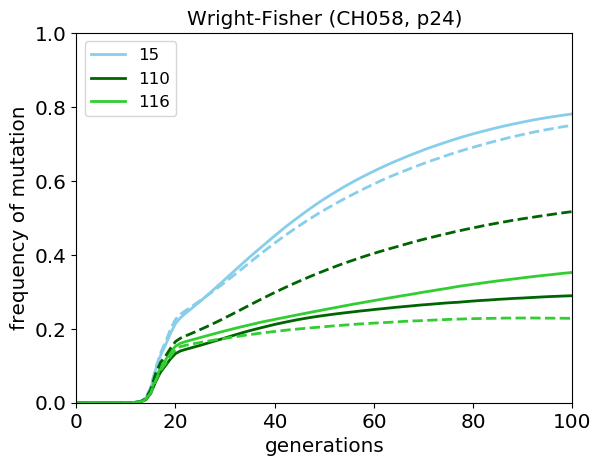

In [21]:
# 181206: plot mutant frequencies

# eptnum=2; site_range=proteptstart[eptnum]:proteptend[eptnum]
site_range=[15,110,116]

legendnames=AbstractString[]
for i in site_range
#     plot(0:tf,mutfreqs[i,1],color=num2color(i),linewidth=2); push!(legendnames,string(i))
    
#     plot(0:tf,meanmutfreqs_original[i,1:tf+1],color=num2color(i),linewidth=2); push!(legendnames,string(i))
#     plot(0:tf,meanmutfreqs_immunod[i,1:tf+1],color=num2color(i),linewidth=2); push!(legendnames,string(i))
    plot(0:tf,meanmutfreqs_NL43[i,1:tf+1],color=num2color(i),linewidth=2); push!(legendnames,string(i))
end
for i in site_range
    plot(0:tf,meanmutfreqs_original[i,1:tf+1],color=num2color(i),linewidth=2,linestyle="--")
end

title("Wright-Fisher ($patientid, $protein)",fontsize="x-large")
xlabel("generations",fontsize="x-large")
ylabel("frequency of mutation",fontsize="x-large")
xticks(fontsize="x-large")
yticks(fontsize="x-large")
xlim(0,tf)
ylim(0,1)
if length(site_range)<=10
    boxloc=[0,1]
    legend(legendnames,loc="upper left", bbox_to_anchor=boxloc, borderaxespad=0.5,fontsize="large")
end;

### Multiple Wright-Fisher simulations

In [18]:
num_runs=500
totprevruns=308 # to add to Wright-Fisher simulation results over several sessions

for n=totprevruns+1:num_runs
    @time seqsMat=run_WrightFisher(Jbeta,L,mu,N,rho,seqs_init,tf,
                ept_on="on",ept_start=proteptstart,ept_end=proteptend,ept_field=ept_field,ept_init=proteptbinary)
    
    # 181206: compute mutant frequencies
    mutfreqs=(sum(seqsMat,dims=2)/N)[:,1,:]
    writedlm("/Volumes/My Passport/Wright-Fisher results/original/mutfreqs"*string(n)*".txt",mutfreqs)
end

 96.954235 seconds (31.93 M allocations: 103.210 GiB, 32.92% gc time)
115.249686 seconds (31.93 M allocations: 103.210 GiB, 30.60% gc time)
100.254042 seconds (31.94 M allocations: 103.210 GiB, 33.81% gc time)
 86.526544 seconds (31.93 M allocations: 103.210 GiB, 33.60% gc time)
 91.782654 seconds (31.93 M allocations: 103.210 GiB, 34.54% gc time)
 79.546896 seconds (31.93 M allocations: 103.210 GiB, 35.55% gc time)
 79.820421 seconds (31.94 M allocations: 103.212 GiB, 35.14% gc time)
 79.768912 seconds (31.94 M allocations: 103.211 GiB, 35.26% gc time)
 80.279008 seconds (31.93 M allocations: 103.210 GiB, 35.55% gc time)
 79.707217 seconds (31.94 M allocations: 103.212 GiB, 35.04% gc time)
 79.772185 seconds (31.93 M allocations: 103.209 GiB, 35.34% gc time)
 79.629708 seconds (31.94 M allocations: 103.211 GiB, 35.49% gc time)
 79.990195 seconds (31.93 M allocations: 103.210 GiB, 35.71% gc time)
 81.429443 seconds (31.94 M allocations: 103.211 GiB, 34.63% gc time)
 80.534664 seconds (

 79.975328 seconds (31.93 M allocations: 103.210 GiB, 34.92% gc time)
 80.126769 seconds (31.93 M allocations: 103.210 GiB, 35.77% gc time)
 80.094460 seconds (31.93 M allocations: 103.210 GiB, 35.29% gc time)
 80.541612 seconds (31.93 M allocations: 103.210 GiB, 35.17% gc time)
 80.655682 seconds (31.94 M allocations: 103.211 GiB, 35.47% gc time)
 81.358867 seconds (31.94 M allocations: 103.211 GiB, 35.67% gc time)
 80.996812 seconds (31.94 M allocations: 103.211 GiB, 35.83% gc time)
 80.983453 seconds (31.93 M allocations: 103.210 GiB, 35.90% gc time)
 80.602117 seconds (31.94 M allocations: 103.211 GiB, 34.81% gc time)
 80.339289 seconds (31.93 M allocations: 103.210 GiB, 35.92% gc time)
 81.071926 seconds (31.93 M allocations: 103.210 GiB, 35.95% gc time)
 80.641102 seconds (31.93 M allocations: 103.209 GiB, 35.59% gc time)
 81.093343 seconds (31.94 M allocations: 103.210 GiB, 36.03% gc time)
 80.388716 seconds (31.94 M allocations: 103.211 GiB, 35.89% gc time)
 80.561117 seconds (

### 181213: Wright-Fisher with immunodominance

In [19]:
# 180517: implement immunodominance
immunod=[1/6,5/6]
ept_field_immunod=zeros(num_ept,tf+1)
for k=1:num_ept
    ept_field_immunod[k,:]=immunod[k]*b_tot*cat(zeros(t_0_naive),b_Hill_vec_naive,dims=1)
end

num_runs=500
totprevruns=2 # to add to Wright-Fisher simulation results over several sessions

for n=totprevruns+1:num_runs
    seqsMat=run_WrightFisher(Jbeta,L,mu,N,rho,seqs_init,tf,
                ept_on="on",ept_start=proteptstart,ept_end=proteptend,ept_field=ept_field_immunod,ept_init=proteptbinary)
#     writedlm("/Volumes/My Passport/Wright-Fisher results/immunodominance/seqsMat"*string(n)*".txt",seqsMat)
    
    # 181206: compute mutant frequencies
    mutfreqs=(sum(seqsMat,dims=2)/N)[:,1,:]
    writedlm("/Volumes/My Passport/Wright-Fisher results/immunodominance/mutfreqs"*string(n)*".txt",mutfreqs)
end

## (1.1) Mutant frequencies

In [27]:
# 180820: find site with largest mutant frequency for each run

eptnum=2; site_range=proteptstart[eptnum]:proteptend[eptnum]
hist_runs=zeros(length(site_range))

for n=1:num_runs
    max_site=findfirst(isequal(maximum(mutfreqs_all_original[site_range,end,n])),mutfreqs_all_original[site_range,end,n])
    hist_runs[max_site]+=1
end

hist_runs

10-element Array{Float64,1}:
   4.0
   4.0
 262.0
   4.0
   6.0
   4.0
   2.0
  98.0
 116.0
   0.0

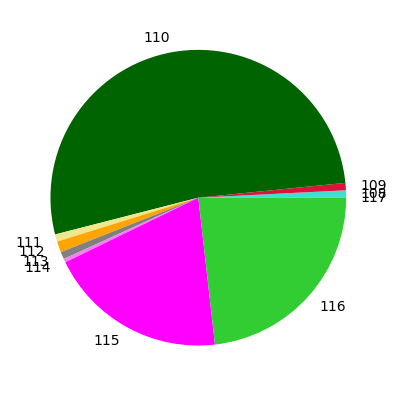

In [28]:
# 180820: create pie chart of largest-frequency mutations in epitope among the simulation runs

# 180821: create same color scheme as num2color()
ept_colors=String[]
for i in site_range
    push!(ept_colors,num2color(i))
end

pie(hist_runs,labels=collect(site_range),colors=ept_colors);